# **Buenos_Aires_Real_Estate: Predicting Price with Neighborhood**

In [20]:
# Imported libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import glob
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

## **Import data**

### **Task 2.1.1: Write a function named wrangle that takes a file path as an argument and returns a DataFrame.**

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

### **Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the directory. Assign this list to the variable name files**

In [8]:
files = glob.glob("buenos-aires-real-estate-*.csv")
files

['buenos-aires-real-estate-4.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-5.csv',
 'buenos-aires-real-estate-3.csv']

### **Use your wrangle function in a for loop to create a list named frames. The list should the cleaned DataFrames created from the CSV filenames your collected in files.**


In [9]:
frames = []

for file in files:
    df = wrangle(file)
    #print(df.shape)
    frames.append(df)

### **Use pd.concat to concatenate the items in frames into a single DataFrame df. Make sure you set the ignore_index argument to True**

In [10]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,59000.0,USD,894581.60,59000.0,0.0,40.0,NaN,1475.000000,NaN,2.0,NaN,http://paternal.properati.com.ar/12t3j_venta_d...,-34.604069,-58.460209,Paternal
1,sell,apartment,78900.0,USD,1196313.36,78900.0,43.0,38.0,1834.883721,2076.315789,1.0,1.0,1600.0,http://congreso.properati.com.ar/12j7y_venta_d...,-34.620026,-58.388467,Congreso
2,sell,apartment,240000.0,USD,3638976.00,240000.0,97.0,88.0,2474.226804,2727.272727,NaN,4.0,NaN,http://agronomia.properati.com.ar/10vec_venta_...,-34.599857,-58.489002,Agronomía
3,sell,apartment,75000.0,USD,1137180.00,75000.0,NaN,34.0,NaN,2205.882353,4.0,2.0,NaN,http://balvanera.properati.com.ar/10vnl_venta_...,-34.612338,-58.401328,Balvanera
4,sell,apartment,110000.0,USD,1667864.00,110000.0,NaN,46.0,NaN,2391.304348,2.0,2.0,NaN,http://parque-chas.properati.com.ar/yc23_venta...,-34.586160,-58.475633,Parque Chas


## **Split**

### **Create your feature matrix X_train and target vector y_train. X_train should contain one feature: "neighborhood". Your target is "price_aprox_usd".**

In [11]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

## **Build Model**

### **Baseline**
### **Calculate the baseline mean absolute error for your model.**

In [12]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)

MAE = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline MAE:", MAE)

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


## **Iterate**

### **First, instantiate a OneHotEncoder named ohe. Make sure to set the use_cat_names argument to True. Next, fit your transformer to the feature matrix X_train. Finally, use your encoder to transform the feature matrix X_train, and assign the transformed data to the variable XT_train.**

In [18]:
# Instantiate
ohe = OneHotEncoder(sparse_output=False)

# Fit
ohe.fit(X_train)

# Transform
XT_train = ohe.transform(X_train)

# Convert to DataFrame for better readability
XT_train_df = pd.DataFrame(XT_train, columns=ohe.get_feature_names_out(X_train.columns))

print(XT_train_df.shape)
XT_train_df.head()

(6582, 57)


,neighborhood_,neighborhood_Abasto,neighborhood_Agronomía,neighborhood_Almagro,neighborhood_Balvanera,neighborhood_Barracas,neighborhood_Barrio Norte,neighborhood_Belgrano,neighborhood_Boca,neighborhood_Boedo,neighborhood_Caballito,neighborhood_Catalinas,neighborhood_Centro / Microcentro,neighborhood_Chacarita,neighborhood_Coghlan,neighborhood_Colegiales,neighborhood_Congreso,neighborhood_Constitución,neighborhood_Flores,neighborhood_Floresta,neighborhood_Las Cañitas,neighborhood_Liniers,neighborhood_Mataderos,neighborhood_Monserrat,neighborhood_Monte Castro,neighborhood_Nuñez,neighborhood_Once,neighborhood_Palermo,neighborhood_Parque Avellaneda,neighborhood_Parque Centenario,neighborhood_Parque Chacabuco,neighborhood_Parque Chas,neighborhood_Parque Patricios,neighborhood_Paternal,neighborhood_Pompeya,neighborhood_Puerto Madero,neighborhood_Recoleta,neighborhood_Retiro,neighborhood_Saavedra,neighborhood_San Cristobal,neighborhood_San Nicolás,neighborhood_San Telmo,neighborhood_Tribunales,neighborhood_Velez Sarsfield,neighborhood_Versalles,neighborhood_Villa Crespo,neighborhood_Villa Devoto,neighborhood_Villa General Mitre,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Create a pipeline named model that contains a OneHotEncoder transformer and a LinearRegression predictor. Then fit your model to the training data..**

In [21]:
model = make_pipeline(
        OneHotEncoder(),
        Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()), ('ridge', Ridge())])

## **Evaluate**

### **First, create a list of predictions for the observations in your feature matrix X_train. Name this list y_pred_training. Then calculate the training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.**

In [22]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.21


**It looks like our model performs a little better than the baseline. This suggests that latitude and longitude aren't as strong predictors of price as size is.**

In [23]:
#X_test = df[features]
#y_pred_test = pd.Series(model.predict(X_test))
#y_pred_test.head()

# Generate predictions using a trained model in scikit-learn.
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([111417.92416187, 110552.24530013, 117742.82246018, 107352.43437673,
        86071.75659348])

## **Communicate Results**

### **Extract the intercept and coefficients for your model.**

In [24]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-19371.24336123   4332.94449842   -780.52957305   2905.55141187
 -11170.9176565 ]


### **Extract the feature names of your encoded data from the OneHotEncoder in your model.**

In [26]:
feature_names = model.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_' 'neighborhood_Abasto' 'neighborhood_Agronomía'
 'neighborhood_Almagro' 'neighborhood_Balvanera']


### **Create a pandas Series named feat_imp where the index is your features and the values are your coefficients.**

In [27]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_            -19371.243361
neighborhood_Abasto        4332.944498
neighborhood_Agronomía     -780.529573
neighborhood_Almagro       2905.551412
neighborhood_Balvanera   -11170.917656
dtype: float64

### **Run the cell below to print the equation that your model has determined for predicting apartment price based on longitude and latitude.**

In [28]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118523.35
+ (-19371.24 * neighborhood_)
+ (4332.94 * neighborhood_Abasto)
+ (-780.53 * neighborhood_Agronomía)
+ (2905.55 * neighborhood_Almagro)
+ (-11170.92 * neighborhood_Balvanera)
+ (-4616.69 * neighborhood_Barracas)
+ (55592.59 * neighborhood_Barrio Norte)
+ (46955.45 * neighborhood_Belgrano)
+ (-28351.28 * neighborhood_Boca)
+ (-6833.03 * neighborhood_Boedo)
+ (9254.09 * neighborhood_Caballito)
+ (-22004.16 * neighborhood_Catalinas)
+ (-7902.02 * neighborhood_Centro / Microcentro)
+ (-2895.46 * neighborhood_Chacarita)
+ (12220.57 * neighborhood_Coghlan)
+ (38438.2 * neighborhood_Colegiales)
+ (-7971.11 * neighborhood_Congreso)
+ (-41741.38 * neighborhood_Constitución)
+ (-8660.57 * neighborhood_Flores)
+ (-14085.95 * neighborhood_Floresta)
+ (72262.07 * neighborhood_Las Cañitas)
+ (-13726.23 * neighborhood_Liniers)
+ (-21078.57 * neighborhood_Mataderos)
+ (-20289.52 * neighborhood_Monserrat)
+ (-3424.35 * neighborhood_Monte Castro)
+ (42832.96 * neighborhood_Nuñez)
+ (-3

### **Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value**

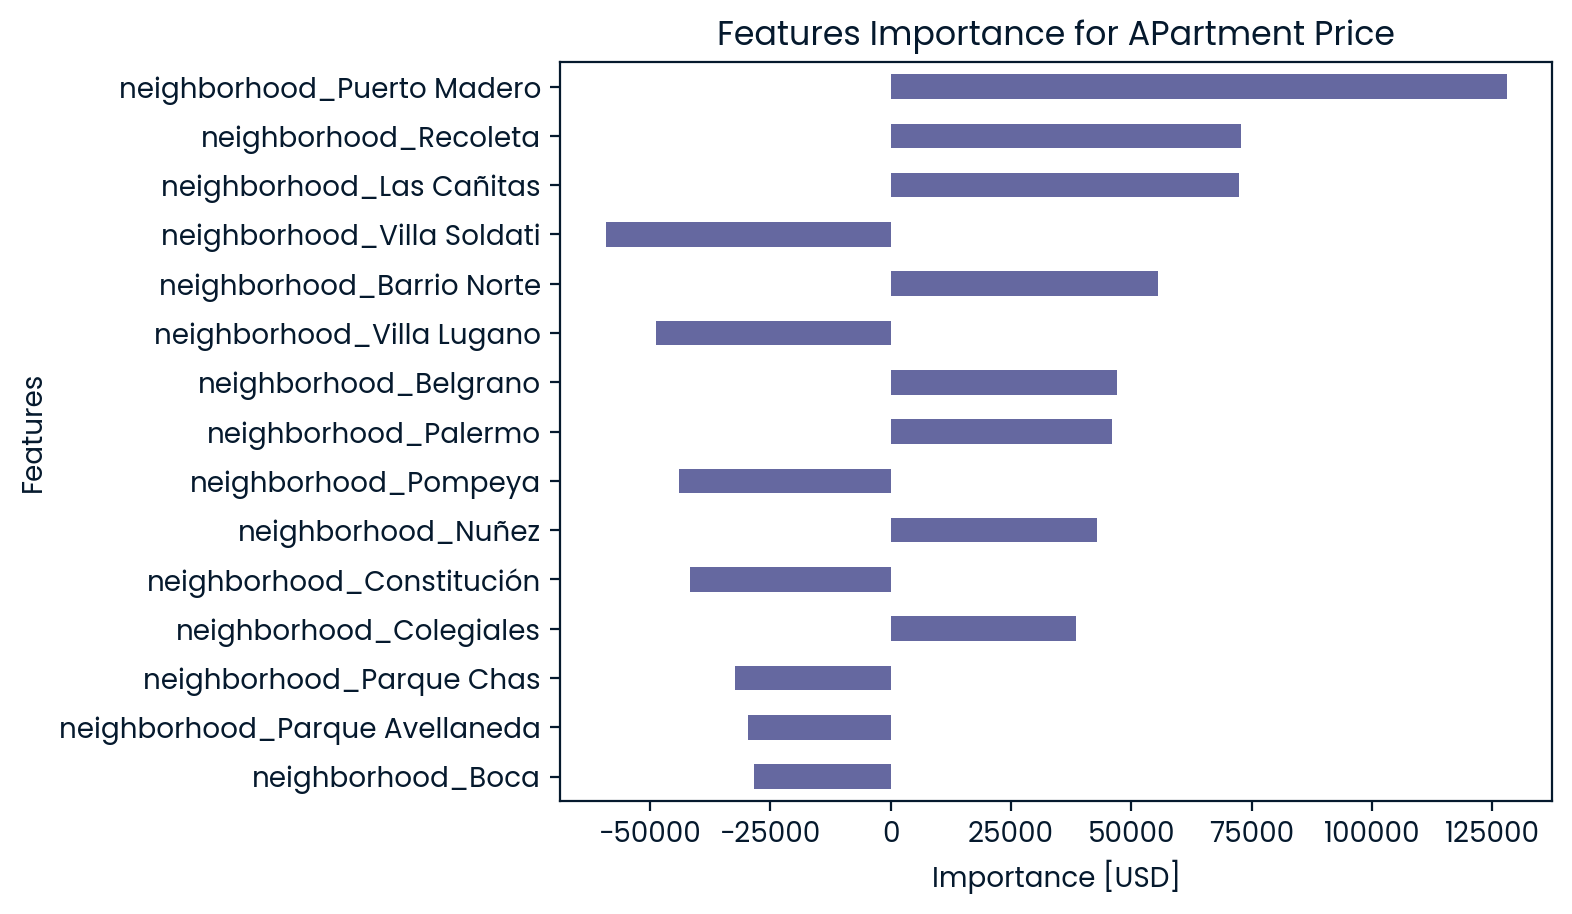

In [30]:
feat_imp.sort_values(key=abs).tail(15).plot(
    kind="barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Features")
plt.title("Features Importance for APartment Price");